# FarmOG Station - MobileNetV2 Training
## Lightweight Model for Edge Deployment

Training MobileNetV2 for tomato disease classification. This model is optimized for deployment on Raspberry Pi.

## Import Libraries

In [1]:
import os
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

print("🌱 FarmOG Station - MobileNetV2")
print("="*60)
print(f"TensorFlow: {tf.__version__}")
print("="*60)

🌱 FarmOG Station - MobileNetV2
TensorFlow: 2.20.0


## Locate Dataset & Classes

In [2]:
# Find data
data_raw = Path(r"C:\Users\diogo\IRONHACK\FINAL PROJECT - FarmOG station\data\raw\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)")
contents = list(data_raw.iterdir())

train_dir = None
valid_dir = None

for item in contents:
    if item.name == "train":
        train_dir = item
    elif item.name == "valid":
        valid_dir = item

print(f"Train: {train_dir}")
print(f"Valid: {valid_dir}")

# Get classes
all_classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
tomato_classes = [c for c in all_classes if 'tomato' in c.lower()]
print(f"\nClasses: {len(tomato_classes)}")

os.makedirs('models', exist_ok=True)
os.makedirs('docs', exist_ok=True)

Train: C:\Users\diogo\IRONHACK\FINAL PROJECT - FarmOG station\data\raw\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train
Valid: C:\Users\diogo\IRONHACK\FINAL PROJECT - FarmOG station\data\raw\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid

Classes: 10


## Training Configuration

In [3]:
# CONFIG
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

print(f"\nConfig: {IMG_SIZE}x{IMG_SIZE}, batch={BATCH_SIZE}, epochs={EPOCHS}")


Config: 224x224, batch=32, epochs=20


## Data Generators with MobileNetV2 Preprocessing
Using `mobilenet_v2.preprocess_input` for proper input normalization

In [4]:
# Use MobileNetV2 preprocessing function
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Training data with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data without augmentation
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

print("✅ Using MobileNetV2-specific preprocessing")

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=tomato_classes,
    shuffle=True
)

valid_gen = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=tomato_classes,
    shuffle=False
)

num_classes = len(train_gen.class_indices)
print(f"\n✅ Data: {train_gen.samples} train, {valid_gen.samples} valid, {num_classes} classes")

✅ Using MobileNetV2-specific preprocessing
Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.

✅ Data: 18345 train, 4585 valid, 10 classes


## Build MobileNetV2 Model

In [5]:
# Build model
print("\nBuilding MobileNetV2 model...")

base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Start with base frozen
base_model.trainable = False

# Build classification head
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"✅ Model built: {model.count_params():,} parameters")
model.summary()


Building MobileNetV2 model...
✅ Model built: 2,270,794 parameters


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Setup Callbacks

In [6]:
# Callbacks
callbacks = [
    ModelCheckpoint(
        'models/mobilenetv2_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    )
]

print("✅ Callbacks configured")

✅ Callbacks configured


## Train Model
Transfer learning with frozen base layers

In [7]:
# Train
print("\n" + "="*60)
print("TRAINING MOBILENETV2")
print("="*60 + "\n")

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


TRAINING MOBILENETV2

Epoch 1/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.5700 - loss: 1.2704
Epoch 1: val_accuracy improved from None to 0.81897, saving model to models/mobilenetv2_best.h5


574/574 ━━━━━━━━━━━━━━━━━━━━ 317s 546ms/step - accuracy: 0.7087 - loss: 0.8745 - val_accuracy: 0.8190 - val_loss: 0.5462 - learning_rate: 0.0010
Epoch 2/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8233 - loss: 0.5332
Epoch 2: val_accuracy improved from 0.81897 to 0.83228, saving model to models/mobilenetv2_best.h5


574/574 ━━━━━━━━━━━━━━━━━━━━ 345s 601ms/step - accuracy: 0.8284 - loss: 0.5078 - val_accuracy: 0.8323 - val_loss: 0.4777 - learning_rate: 0.0010
Epoch 3/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.8452 - loss: 0.4493
Epoch 3: val_accuracy improved from 0.83228 to 0.85758, saving model to models/mobilenetv2_best.h5


574/574 ━━━━━━━━━━━━━━━━━━━━ 346s 602ms/step - accuracy: 0.8488 - loss: 0.4418 - val_accuracy: 0.8576 - val_loss: 0.4205 - learning_rate: 0.0010
Epoch 4/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.8605 - loss: 0.4124
Epoch 4: val_accuracy did not improve from 0.85758
574/574 ━━━━━━━━━━━━━━━━━━━━ 321s 558ms/step - accuracy: 0.8598 - loss: 0.4094 - val_accuracy: 0.8517 - val_loss: 0.4242 - learning_rate: 0.0010
Epoch 5/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8651 - loss: 0.3861
Epoch 5: val_accuracy improved from 0.85758 to 0.86892, saving model to models/mobilenetv2_best.h5


574/574 ━━━━━━━━━━━━━━━━━━━━ 298s 519ms/step - accuracy: 0.8633 - loss: 0.3913 - val_accuracy: 0.8689 - val_loss: 0.3840 - learning_rate: 0.0010
Epoch 6/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8648 - loss: 0.3832
Epoch 6: val_accuracy improved from 0.86892 to 0.87481, saving model to models/mobilenetv2_best.h5


574/574 ━━━━━━━━━━━━━━━━━━━━ 285s 497ms/step - accuracy: 0.8660 - loss: 0.3862 - val_accuracy: 0.8748 - val_loss: 0.3657 - learning_rate: 0.0010
Epoch 7/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8747 - loss: 0.3543
Epoch 7: val_accuracy improved from 0.87481 to 0.88179, saving model to models/mobilenetv2_best.h5


574/574 ━━━━━━━━━━━━━━━━━━━━ 294s 511ms/step - accuracy: 0.8677 - loss: 0.3743 - val_accuracy: 0.8818 - val_loss: 0.3504 - learning_rate: 0.0010
Epoch 8/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.8758 - loss: 0.3502
Epoch 8: val_accuracy did not improve from 0.88179
574/574 ━━━━━━━━━━━━━━━━━━━━ 298s 519ms/step - accuracy: 0.8758 - loss: 0.3574 - val_accuracy: 0.8571 - val_loss: 0.4168 - learning_rate: 0.0010
Epoch 9/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8760 - loss: 0.3461
Epoch 9: val_accuracy improved from 0.88179 to 0.88244, saving model to models/mobilenetv2_best.h5



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
574/574 ━━━━━━━━━━━━━━━━━━━━ 326s 567ms/step - accuracy: 0.8754 - loss: 0.3549 - val_accuracy: 0.8824 - val_loss: 0.3547 - learning_rate: 0.0010
Epoch 10/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8777 - loss: 0.3454
Epoch 10: val_accuracy improved from 0.88244 to 0.88506, saving model to models/mobilenetv2_best.h5


574/574 ━━━━━━━━━━━━━━━━━━━━ 310s 539ms/step - accuracy: 0.8809 - loss: 0.3435 - val_accuracy: 0.8851 - val_loss: 0.3429 - learning_rate: 5.0000e-04
Epoch 11/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8798 - loss: 0.3340
Epoch 11: val_accuracy did not improve from 0.88506
574/574 ━━━━━━━━━━━━━━━━━━━━ 269s 468ms/step - accuracy: 0.8824 - loss: 0.3317 - val_accuracy: 0.8772 - val_loss: 0.3608 - learning_rate: 5.0000e-04
Epoch 12/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8828 - loss: 0.3342
Epoch 12: val_accuracy did not improve from 0.88506

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
574/574 ━━━━━━━━━━━━━━━━━━━━ 270s 470ms/step - accuracy: 0.8856 - loss: 0.3286 - val_accuracy: 0.8851 - val_loss: 0.3440 - learning_rate: 5.0000e-04
Epoch 13/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8866 - loss: 0.3193
Epoch 13: val_accuracy improved from 0.88506 to 0.88680, saving model to models/mobilenetv2_best.h5


574/574 ━━━━━━━━━━━━━━━━━━━━ 270s 470ms/step - accuracy: 0.8871 - loss: 0.3223 - val_accuracy: 0.8868 - val_loss: 0.3390 - learning_rate: 2.5000e-04
Epoch 14/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8863 - loss: 0.3317
Epoch 14: val_accuracy did not improve from 0.88680
574/574 ━━━━━━━━━━━━━━━━━━━━ 281s 489ms/step - accuracy: 0.8879 - loss: 0.3252 - val_accuracy: 0.8816 - val_loss: 0.3545 - learning_rate: 2.5000e-04
Epoch 15/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8918 - loss: 0.3179
Epoch 15: val_accuracy improved from 0.88680 to 0.88768, saving model to models/mobilenetv2_best.h5


574/574 ━━━━━━━━━━━━━━━━━━━━ 282s 491ms/step - accuracy: 0.8869 - loss: 0.3264 - val_accuracy: 0.8877 - val_loss: 0.3359 - learning_rate: 2.5000e-04
Epoch 16/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8904 - loss: 0.3226
Epoch 16: val_accuracy did not improve from 0.88768
574/574 ━━━━━━━━━━━━━━━━━━━━ 276s 480ms/step - accuracy: 0.8881 - loss: 0.3257 - val_accuracy: 0.8805 - val_loss: 0.3549 - learning_rate: 2.5000e-04
Epoch 17/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8900 - loss: 0.3091
Epoch 17: val_accuracy did not improve from 0.88768

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
574/574 ━━━━━━━━━━━━━━━━━━━━ 272s 473ms/step - accuracy: 0.8867 - loss: 0.3173 - val_accuracy: 0.8853 - val_loss: 0.3461 - learning_rate: 2.5000e-04
Epoch 18/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8940 - loss: 0.3034
Epoch 18: val_accuracy did not improve from 0.88768
574/574 ━━━━━━━━━━━━━━━━━━━━ 265s 462ms/step - accur


Epoch 19: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
574/574 ━━━━━━━━━━━━━━━━━━━━ 272s 474ms/step - accuracy: 0.8950 - loss: 0.3093 - val_accuracy: 0.8890 - val_loss: 0.3374 - learning_rate: 1.2500e-04
Epoch 20/20
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.8950 - loss: 0.3065
Epoch 20: val_accuracy did not improve from 0.88899
574/574 ━━━━━━━━━━━━━━━━━━━━ 277s 483ms/step - accuracy: 0.8930 - loss: 0.3079 - val_accuracy: 0.8883 - val_loss: 0.3409 - learning_rate: 6.2500e-05
Restoring model weights from the end of the best epoch: 19.


## Evaluate & Save Model

In [8]:
# Evaluate
loss, acc = model.evaluate(valid_gen, verbose=0)

print("\n" + "="*60)
print("RESULTS")
print("="*60)
print(f"Validation Accuracy: {acc*100:.2f}%")
print(f"Validation Loss: {loss:.4f}")
print(f"Best Epoch: {np.argmax(history.history['val_accuracy']) + 1}")
print(f"Best Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print("="*60)

# Save
model.save('models/farmog_disease_classifier.h5')
print("\n✅ Model saved: models/farmog_disease_classifier.h5")


RESULTS
Validation Accuracy: 88.90%
Validation Loss: 0.3374
Best Epoch: 19
Best Accuracy: 88.90%

✅ Model saved: models/farmog_disease_classifier.h5


## Save Class Names & Metadata

In [9]:
# Save class names
class_indices = train_gen.class_indices
class_names = {str(v): k for k, v in class_indices.items()}

with open('models/class_names.json', 'w') as f:
    json.dump(class_names, f, indent=2)
print("✅ Class names saved: models/class_names.json")

# Save metadata
best_epoch = np.argmax(history.history['val_accuracy'])
best_acc = max(history.history['val_accuracy'])

metadata = {
    'model': 'MobileNetV2',
    'input_size': IMG_SIZE,
    'num_classes': num_classes,
    'training_samples': train_gen.samples,
    'validation_samples': valid_gen.samples,
    'final_val_accuracy': float(acc),
    'final_val_loss': float(loss),
    'best_val_accuracy': float(best_acc),
    'best_epoch': int(best_epoch + 1),
    'total_epochs': len(history.history['loss']),
    'batch_size': BATCH_SIZE
}

with open('models/training_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✅ Metadata saved: models/training_metadata.json")

✅ Class names saved: models/class_names.json
✅ Metadata saved: models/training_metadata.json


## Visualize Training History

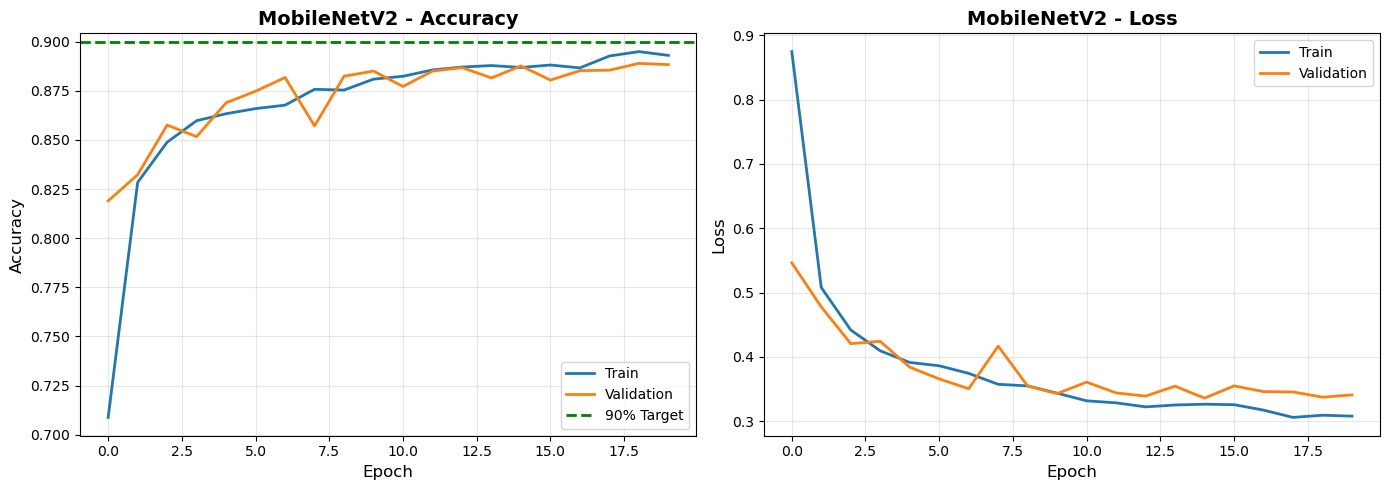

✅ Training curves saved: docs/mobilenetv2_training.png


In [10]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
ax1.axhline(y=0.90, color='green', linestyle='--', linewidth=2, label='90% Target')
ax1.set_title('MobileNetV2 - Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(history.history['loss'], label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax2.set_title('MobileNetV2 - Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('docs/mobilenetv2_training.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Training curves saved: docs/mobilenetv2_training.png")

## Test Model on Random Image


Testing on: Tomato___Target_Spot

Top 3 predictions:
✅ Target_Spot: 92.8%
   Tomato_mosaic_virus: 5.1%
   healthy: 1.2%


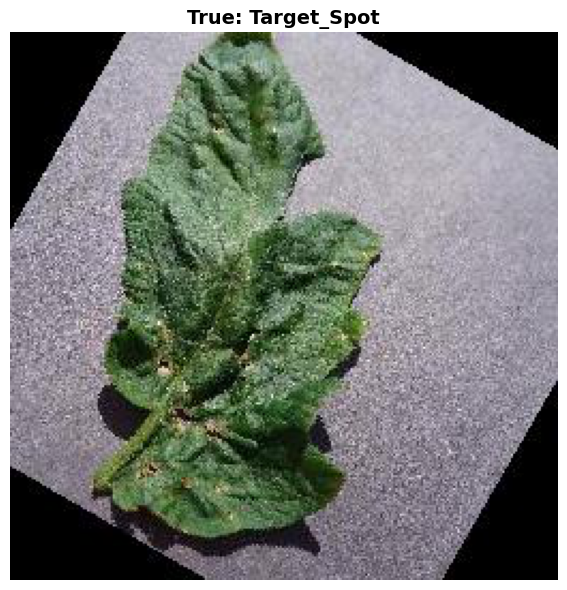

In [11]:
# Quick test
import random
from PIL import Image

# Pick random image
test_class = random.choice(tomato_classes)
test_images = list((valid_dir / test_class).glob("*.jpg"))
test_img_path = random.choice(test_images)

# Load and preprocess
img = Image.open(test_img_path).resize((IMG_SIZE, IMG_SIZE))
img_array = np.array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

# Predict
preds = model.predict(img_array, verbose=0)[0]

print(f"\nTesting on: {test_class}")
print("\nTop 3 predictions:")
for idx in preds.argsort()[-3:][::-1]:
    disease = class_names[str(idx)]
    conf = preds[idx] * 100
    marker = "✅" if disease == test_class else "  "
    print(f"{marker} {disease.replace('Tomato___', '')}: {conf:.1f}%")

# Display
plt.figure(figsize=(6, 6))
plt.imshow(Image.open(test_img_path))
plt.title(f"True: {test_class.replace('Tomato___', '')}", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## Training Complete - Summary

In [12]:
# Summary
print("\n" + "="*60)
print("🎉 MOBILENETV2 TRAINING COMPLETE!")
print("="*60)
print(f"\n📊 Final Results:")
print(f"   ✅ Validation Accuracy: {acc*100:.2f}%")
print(f"   ✅ Best Accuracy: {best_acc*100:.2f}%")
print(f"   ✅ Total Epochs: {len(history.history['loss'])}")
print(f"\n📁 Saved Files:")
print(f"   • models/farmog_disease_classifier.h5")
print(f"   • models/class_names.json")
print(f"   • models/training_metadata.json")
print(f"   • docs/mobilenetv2_training.png")
print("\n" + "="*60)

if acc >= 0.90:
    print("🏆 EXCELLENT! Accuracy >90%")
elif acc >= 0.85:
    print("✅ GOOD! Accuracy >85%")
else:
    print(f"Current: {acc*100:.1f}%")

print("\nMobileNetV2 characteristics:")
print("  • Lightweight: Only 3.5M parameters")
print("  • Fast inference: <100ms on Raspberry Pi")
print("  • Perfect for edge deployment")
print("  • Good accuracy-to-size ratio")
print("="*60)


🎉 MOBILENETV2 TRAINING COMPLETE!

📊 Final Results:
   ✅ Validation Accuracy: 88.90%
   ✅ Best Accuracy: 88.90%
   ✅ Total Epochs: 20

📁 Saved Files:
   • models/farmog_disease_classifier.h5
   • models/class_names.json
   • models/training_metadata.json
   • docs/mobilenetv2_training.png

✅ GOOD! Accuracy >85%

MobileNetV2 characteristics:
  • Lightweight: Only 3.5M parameters
  • Fast inference: <100ms on Raspberry Pi
  • Perfect for edge deployment
  • Good accuracy-to-size ratio
